In [10]:
#Note: we denote L2 for euclidian norm and l2 for function norm (we switched the standard nomenclature)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Extracting the results

In [1]:
from os import listdir
from os.path import isfile, join
import pickle
import pandas as pd

folder = "/Users/mehdi/Downloads/2017-05-03_19.50.24/"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K"))]

def data_extract_from_files(onlyfiles):
    for f in onlyfiles:
        yield pickle.load(open(folder+f)), f

In [2]:
data_tree = {}
for k in [0, 10,50,100]:
    data_tree[k]={}
    for n in [100 , 500, 1000]:
        data_tree[k][n]=[]
        
for f in onlyfiles:
    split = f.split('K')[1].split("N")
    for K in [0, 10,50,100]:
        if split[0]==str(K):
            K_ = K
    if split[1].startswith("500"):
        N_ = 500
    else :
        if pickle.load(open(folder+f))["rect_data"].shape[0] == 100:
            N_ = 100
        else:
            N_ = 1000
    data_tree[K_][N_].append(f)

In [3]:
import numpy as np
import uuid


In [4]:
from pythonABC.hselect import hsj
from scipy.stats import gaussian_kde
from scipy.stats import entropy

def results_extract(r):
    #return dict
    #
    densities = r["densities"]
    res = {}
    for type_dens in ["lapl_gauss", "uniform", "rect", "lapl_gauss_not_dict", "gauss"]:
        f_star = r[type_dens+"_f_star"]
        n_pdf = f_star.shape[0]
        x = np.linspace(0,1,n_pdf)
        #extract weight_estim
        res_weights_estim = r[type_dens+"_weight_vector_estim_lambda"]
        selected_densities_estim, weights_estim = np.array(zip(*res_weights_estim))
        f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))
        #removing non positive values:
        f_weight_estim[f_weight_estim <= 0] == 1e-20
        #extract adapative_dantzig
        lambda_adapative_dantzig = r[type_dens+"_adapative_dantzig"]
        f_adapative_dantzig = np.apply_along_axis(lambda x: lambda_adapative_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))        
        #removing non positive values:
        f_adapative_dantzig[f_adapative_dantzig <= 0] == 1e-20
        #Extract KDE
        f_kde= r[type_dens+"_kde"]
        #Extract KDE-hsj
        f_kde_hsj= r[type_dens+"_kde_hsj"]        
        #Perform kernel density estim
        res[type_dens+"_L2_norm_weight_estim"] = 1./n_pdf*np.linalg.norm(f_star-f_weight_estim,axis=0)**2
        res[type_dens+"_KL_div_weight_estim"] = entropy(f_star, f_weight_estim)
        res[type_dens+"_L2_norm_adapative_dantzig"] = 1./n_pdf*np.linalg.norm(f_star-f_adapative_dantzig,axis=0)**2
        res[type_dens+"_KL_div_adapative_dantzig"] = entropy(f_star, f_adapative_dantzig)
        res[type_dens+"_L2_norm_kde"] = 1./n_pdf*np.linalg.norm(f_star-f_kde,axis=0)**2
        res[type_dens+"_KL_div_kde"] = entropy(f_star, f_kde)
        res[type_dens+"_L2_norm_kde_hsj"] = 1./n_pdf*np.linalg.norm(f_star-f_kde_hsj,axis=0)**2
        res[type_dens+"_KL_div_kde_hsj"] = entropy(f_star, f_kde_hsj)
        if type_dens == "cvx":
            cvx_lambda_fstar = cvx_lambda_f_star(len(densities), r["selected_densities"])
            res[type_dens+"_L2_lambda_adapative_dantzig"] = np.linalg.norm(cvx_lambda_fstar- r["cvx_adapative_dantzig"])
            res[type_dens+"_L2_lambda_weight_estim"] = np.linalg.norm(cvx_lambda_fstar- extract_lambda(r["cvx_weight_vector_estim_lambda"],len(densities)))

    return res

In [5]:
#cvx case:
def dataframe_gen(temp_res, type_f_star):
    data = {type_f_star+"_KL_div_weight_estim":[],
            type_f_star+"_KL_div_adapative_dantzig":[],
            type_f_star+"_KL_div_kde":[],
            type_f_star+"_KL_div_kde_hsj":[],
            type_f_star+"_L2_norm_weight_estim":[],
            type_f_star+"_L2_norm_adapative_dantzig":[],
            type_f_star+"_L2_norm_kde":[],
            type_f_star+"_L2_norm_kde_hsj":[]            }
    if type_f_star == "cvx":
        data["cvx_L2_lambda_weight_estim"] = [temp_res["cvx_L2_lambda_weight_estim"]]
        data["cvx_L2_lambda_adapative_dantzig"] = [temp_res["cvx_L2_lambda_adapative_dantzig"]]

    data[type_f_star+"_KL_div_weight_estim"].append(temp_res[type_f_star+"_KL_div_weight_estim"])
    data[type_f_star+"_KL_div_adapative_dantzig"].append(temp_res[type_f_star+"_KL_div_adapative_dantzig"])
    data[type_f_star+"_KL_div_kde"].append(temp_res[type_f_star+"_KL_div_kde"])
    data[type_f_star+"_KL_div_kde_hsj"].append(temp_res[type_f_star+"_KL_div_kde_hsj"])
    data[type_f_star+"_L2_norm_weight_estim"].append(temp_res[type_f_star+"_L2_norm_weight_estim"])
    data[type_f_star+"_L2_norm_adapative_dantzig"].append(temp_res[type_f_star+"_L2_norm_adapative_dantzig"])
    data[type_f_star+"_L2_norm_kde"].append(temp_res[type_f_star+"_L2_norm_kde"])
    data[type_f_star+"_L2_norm_kde_hsj"].append(temp_res[type_f_star+"_L2_norm_kde_hsj"])
    
    return pd.DataFrame(data)

In [6]:
df_results = None
for K in [0]:
    for N in [100, 500, 1000]:
        object_list = data_extract_from_files(data_tree[K][N])
        for r, f in object_list:
            res_extract = results_extract(r)
            res = None
            for type_f_star in ["lapl_gauss", "uniform", "rect", "lapl_gauss_not_dict", "gauss"]:
                df_extract_temp = dataframe_gen(res_extract, type_f_star)
                if type(res) == pd.core.frame.DataFrame:
                    res = res.join(df_extract_temp)
                else:
                    res = df_extract_temp
            res = res.join(pd.DataFrame({"K":[K],"N":[N], "file":f}))
            if type(df_results) == pd.core.frame.DataFrame:
                    df_results = df_results.append(res)
            else:
                    df_results = res
                    

In [8]:
def retrieve_type(row):
    type_row=row["Type"]
    type_dens = "None"
    if "KL" in type_row:
        metric = "KL"
    else:
        metric = "L2"
    for t in ["lapl_gauss_not_dict", "lapl_gauss", "uniform", "rect", "gauss"]:
        if t == type_row.split("_"+metric)[0]:
            type_dens = t
    if "weight_estim" in type_row:
            method = "MLE"
    if "adapative_dantzig" in type_row:
            method = "A.D"
    if "kde" in type_row:
            if "hsj" in type_row:
                method = "KDE SJ"
            else:
                method = "KDE"
    
    return pd.Series({"metric":metric, "type_dens":type_dens, "method": method})

df3 = pd.melt(df_results.drop(["K","file"], axis=1), id_vars=["N"], var_name="Type", value_name="Loss")
df5 = pd.concat([df3,df3.apply(retrieve_type, axis=1)], axis=1)
df5.to_csv("./cleaned_results_N_100_500_1000_03-05-2017.csv")

# Ploting 

In [31]:
%matplotlib inline
df_results.columns

Index([u'lapl_gauss_KL_div_adapative_dantzig', u'lapl_gauss_KL_div_kde',
       u'lapl_gauss_KL_div_kde_hsj', u'lapl_gauss_KL_div_weight_estim',
       u'lapl_gauss_L2_norm_adapative_dantzig', u'lapl_gauss_L2_norm_kde',
       u'lapl_gauss_L2_norm_kde_hsj', u'lapl_gauss_L2_norm_weight_estim',
       u'uniform_KL_div_adapative_dantzig', u'uniform_KL_div_kde',
       u'uniform_KL_div_kde_hsj', u'uniform_KL_div_weight_estim',
       u'uniform_L2_norm_adapative_dantzig', u'uniform_L2_norm_kde',
       u'uniform_L2_norm_kde_hsj', u'uniform_L2_norm_weight_estim',
       u'rect_KL_div_adapative_dantzig', u'rect_KL_div_kde',
       u'rect_KL_div_kde_hsj', u'rect_KL_div_weight_estim',
       u'rect_L2_norm_adapative_dantzig', u'rect_L2_norm_kde',
       u'rect_L2_norm_kde_hsj', u'rect_L2_norm_weight_estim',
       u'lapl_gauss_not_dict_KL_div_adapative_dantzig',
       u'lapl_gauss_not_dict_KL_div_kde',
       u'lapl_gauss_not_dict_KL_div_kde_hsj',
       u'lapl_gauss_not_dict_KL_div_weight_est

In [32]:
### attention: il y a eu un inversement de kde et kde-hsj, dans la generation des premiers resultats
###
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,20))
colors = ['lightblue', 'lightgreen', 'tan', 'pink']
def boxplot_params(boxplotElements):
    for element in boxplotElements['medians']:
        element.set_color('red')
        element.set_linewidth(1)
    for element in boxplotElements['boxes']:
        element.set_linewidth(1)
        element.set_linestyle('-')
    for element in boxplotElements['whiskers']:
        element.set_color('red')
        element.set_linewidth(1)
    for element in boxplotElements['caps']:
        element.set_color('blue')

#####Lapl Gauss
###############
#KL div
plt.subplot(421)
boxplotElements = plt.boxplot([df_results['lapl_gauss_KL_div_kde'],
             df_results['lapl_gauss_KL_div_kde_hsj'],
             df_results['lapl_gauss_KL_div_adapative_dantzig'],
             df_results['lapl_gauss_KL_div_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("Lapl-Gauss dict KL div")
#L2 norm
plt.subplot(422)
boxplotElements = plt.boxplot([df_results['lapl_gauss_L2_norm_kde'],
             df_results['lapl_gauss_L2_norm_kde_hsj'],
             df_results['lapl_gauss_L2_norm_adapative_dantzig'],
             df_results['lapl_gauss_L2_norm_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("Lapl-Gauss dict L2 norm")

##### Gauss
###############
#KL div
plt.subplot(423)
boxplotElements = plt.boxplot([df_results['gauss_KL_div_kde'],
             df_results['gauss_KL_div_kde_hsj'],
             df_results['gauss_KL_div_adapative_dantzig'],
             df_results['gauss_KL_div_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("Gauss dict KL div")
#L2 norm
plt.subplot(424)
boxplotElements = plt.boxplot([df_results['gauss_L2_norm_kde'],
             df_results['gauss_L2_norm_kde_hsj'],
             df_results['gauss_L2_norm_adapative_dantzig'],
             df_results['gauss_L2_norm_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("Gauss dict L2 norm")

##### lapl_gauss_not_dict
###############
#KL div
plt.subplot(425)
boxplotElements = plt.boxplot([df_results['lapl_gauss_not_dict_KL_div_kde'],
             df_results['lapl_gauss_not_dict_KL_div_kde_hsj'],
             df_results['lapl_gauss_not_dict_KL_div_adapative_dantzig'],
             df_results['lapl_gauss_not_dict_KL_div_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("lapl_gauss_not_dict dict KL div")
#L2 norm
plt.subplot(426)
boxplotElements = plt.boxplot([df_results['lapl_gauss_not_dict_L2_norm_kde'],
             df_results['lapl_gauss_not_dict_L2_norm_kde_hsj'],
             df_results['lapl_gauss_not_dict_L2_norm_adapative_dantzig'],
             df_results['lapl_gauss_not_dict_L2_norm_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("lapl_gauss_not_dict dict L2 norm")

##### uniform
###############
#KL div
plt.subplot(427)
boxplotElements = plt.boxplot([df_results['uniform_KL_div_kde'],
             df_results['uniform_KL_div_kde_hsj'],
             df_results['uniform_KL_div_adapative_dantzig'],
             df_results['uniform_KL_div_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("uniform dict KL div")
#L2 norm
plt.subplot(428)
boxplotElements = plt.boxplot([df_results['uniform_L2_norm_kde'],
             df_results['uniform_L2_norm_kde_hsj'],
             df_results['uniform_L2_norm_adapative_dantzig'],
             df_results['uniform_L2_norm_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("uniform dict L2 norm")
plt.savefig("./plot_"+str(uuid.uuid4()), dpi=300)


RuntimeError: LaTeX was not able to process the following string:
'lapl_gauss_not_dict dict KL div'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./82bcdda10fe35a315300984b965b9e2e.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 82bcdda10fe35a315300984b965b9e2e.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...size{24.000000}{30.000000}{\sffamily lapl_
                                                  gauss_not_dict dict KL div}
! Extra }, or forgotten $.
l.12 ...\sffamily lapl_gauss_not_dict dict KL div}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./82bcdda10fe35a315300984b965b9e2e.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 82bcdda10fe35a315300984b965b9e2e.dvi (1 page, 392 bytes).
Transcript written on 82bcdda10fe35a315300984b965b9e2e.log.


RuntimeError: LaTeX was not able to process the following string:
'lapl_gauss_not_dict dict L2 norm'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./516ded81a94f169b1b50aa4d9f75b155.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 516ded81a94f169b1b50aa4d9f75b155.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...size{24.000000}{30.000000}{\sffamily lapl_
                                                  gauss_not_dict dict L2 norm}
! Extra }, or forgotten $.
l.12 ...sffamily lapl_gauss_not_dict dict L2 norm}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./516ded81a94f169b1b50aa4d9f75b155.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 516ded81a94f169b1b50aa4d9f75b155.dvi (1 page, 440 bytes).
Transcript written on 516ded81a94f169b1b50aa4d9f75b155.log.


# Analysis

# Plot 3 sizes of data

In [17]:
df_final_res = pd.concat(l)

NameError: name 'l' is not defined

In [ ]:
df_final_res.to_csv("results_N_100_500_1000_27-04-2017.csv")

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,10))
colors = ['lightblue', 'lightgreen', 'tan', 'pink']
def boxplot_params(boxplotElements):
    for element in boxplotElements['medians']:
        element.set_color('red')
        element.set_linewidth(1)
    for element in boxplotElements['boxes']:
        element.set_linewidth(1)
        element.set_linestyle('-')
    for element in boxplotElements['whiskers']:
        element.set_color('red')
        element.set_linewidth(1)
    for element in boxplotElements['caps']:
        element.set_color('blue')

#####Lapl Gauss
###############
#KL div
plt.subplot(121)
boxplotElements = plt.boxplot([df_results['lapl_gauss_KL_div_kde'],
             df_results['lapl_gauss_KL_div_kde_hsj'],
             df_results['lapl_gauss_KL_div_adapative_dantzig'],
             df_results['lapl_gauss_KL_div_weight_estim']])
plt.gca().axes.xaxis.set_ticklabels(['KDE-SHJ', 'KDE', 'AD', 'MLE'])
boxplot_params(boxplotElements)
plt.title("Lapl-Gauss dict KL div")


# Generation plots of Thesis Document

In [4]:
import pandas as pd
df5 = pd.read_csv("./cleaned_results_N_100_500_1000_03-05-2017.csv")

In [7]:
%matplotlib inline

In [8]:
import seaborn as sns
def generate_boxplots(df, type_dens, metric):
    plt.figure(figsize=(5,5))
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    boxplot = sns.boxplot(x="method", y="Loss", hue="N", data=df[(df.metric==metric) & (df.type_dens==type_dens)],
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))    
    sns_plot = boxplot.get_figure()
    sns_plot.savefig("../../phd-thesis/TeX_files/output_"+type_dens+"_"+metric+".png")


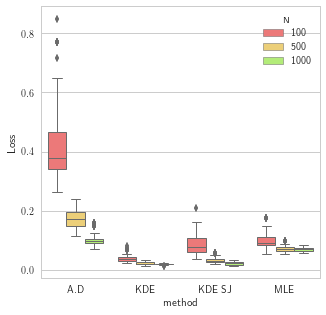

In [9]:
generate_boxplots(df5, "uniform", "L2")

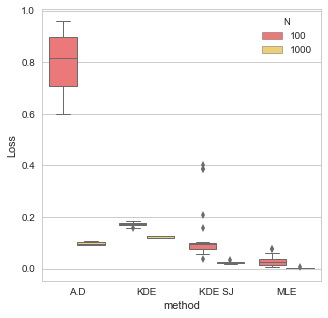

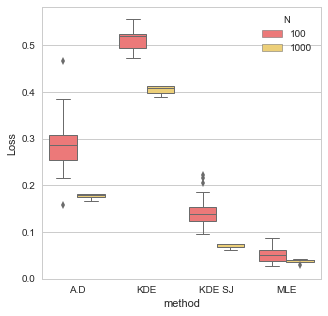

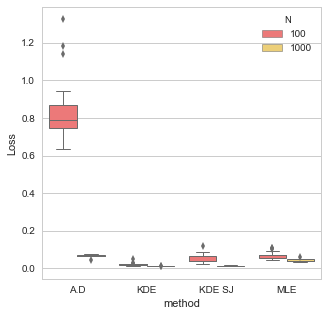

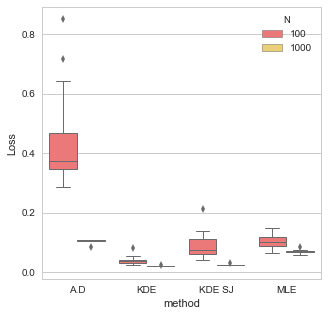

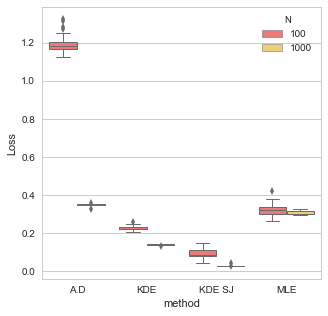

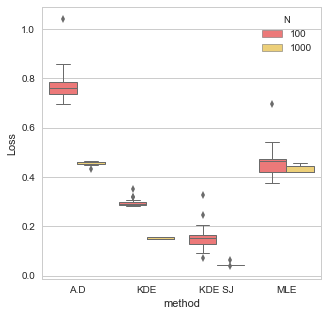

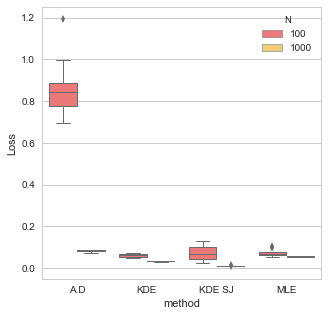

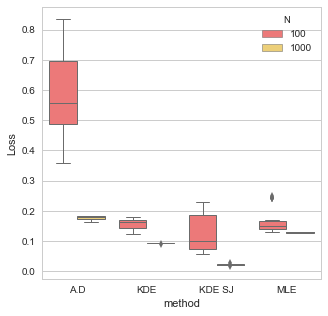

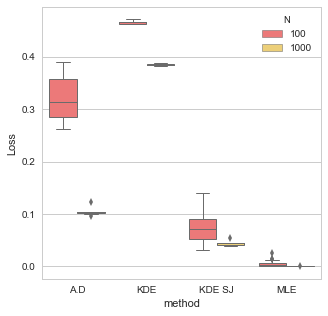

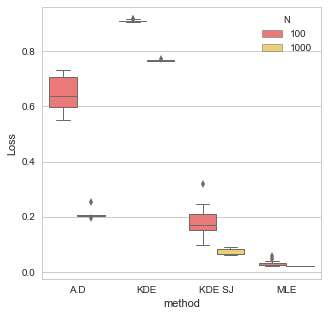

In [22]:
for type_dens in df5.type_dens.unique():
    for metric in ["KL", "L2"]:
        generate_boxplots(df5, type_dens, metric)

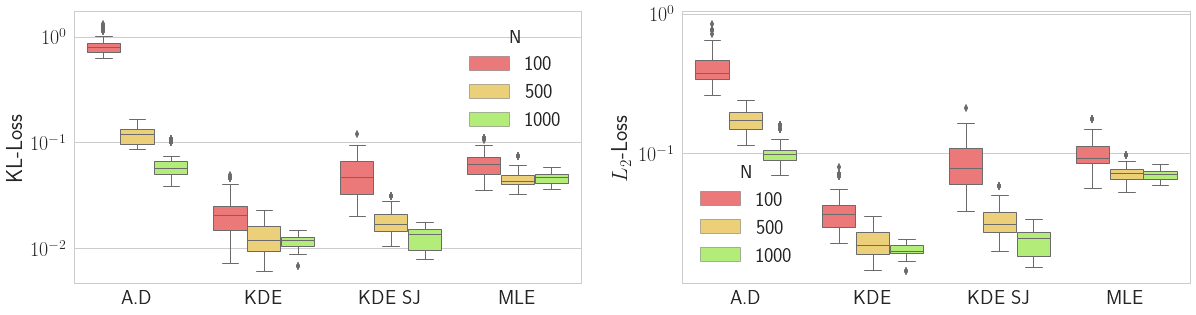

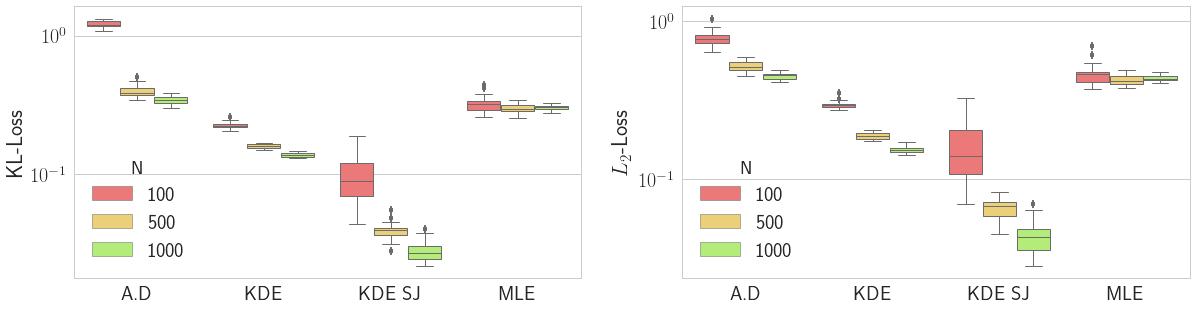

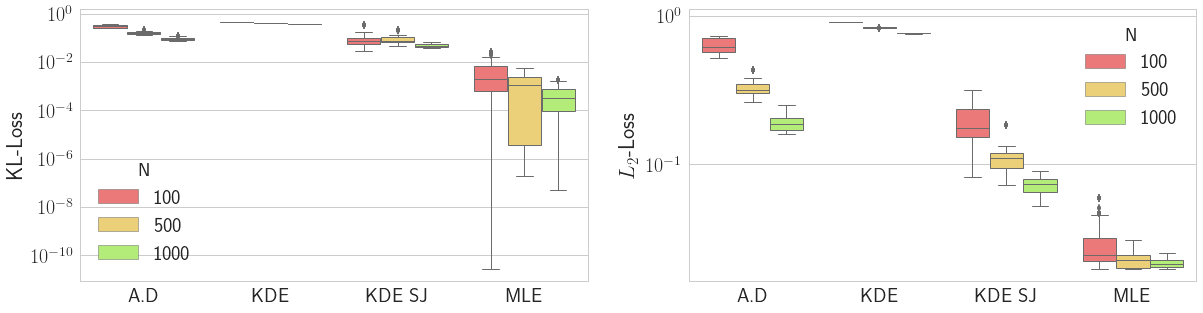

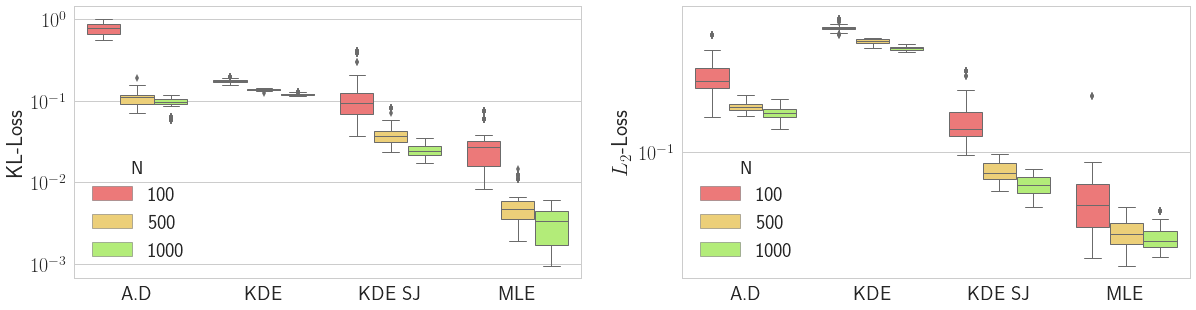

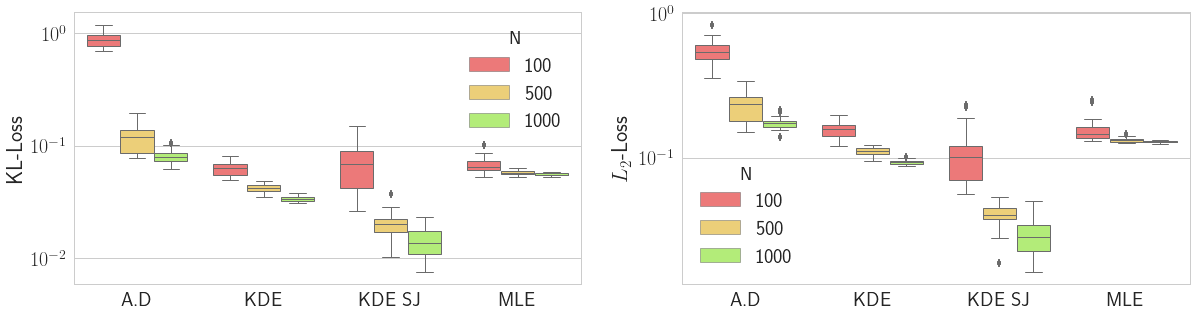

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
def test(df, type_dens, metric, rows, columns, i):
    plt.subplot(rows, columns, i)
    boxplot = sns.boxplot(x="method", y="Loss", hue="N", data=df[(df.metric==metric) & (df.type_dens==type_dens)],
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))
    boxplot.set_xlabel('')
    if metric == 'L2':
        boxplot.set_ylabel(r'$L_2$-Loss')
    else:
        boxplot.set_ylabel(metric+'-Loss')
    sns_plot = boxplot.get_figure()
    for ax in sns_plot.get_axes():
        ax.set_yscale('log')



for type_dens_list in ['uniform', 'rect', 'gauss', 'lapl_gauss','lapl_gauss_not_dict']:
    plt.subplots(figsize=(20,5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
    i=1
    rows = 1
    columns = 2
    for type_dens in [type_dens_list]:
        for metric in ["KL", "L2"]:
            test(df5, type_dens, metric, rows, columns, i)
            i+=1
    plt.savefig("../../phd-thesis/TeX_files/full_results_"+type_dens, dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)